# Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multisensory import detection_params_search
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas as pd
from multiprocess import Pool 

plt.style.use('./style_sheet.mplstyle')

ToDo:

# Hyperparameters

In [2]:
p_ranges = {
    "pm": (0.0, 1.0),  # p of motion
    "pe": (0.0, 1.0),  # p of emitting given there is motion
    "pc": (0.0, 1.0),  # p correct direction when emitting
    "pn": (0.0, 1.0),  # p not neutral when not emitting
    "pi": (0.0, 0.5),  # p incorrect when emitting
}
p_labels = ["$p_m$", "$p_e$", "$p_c$", "$p_n$", "$p_i$"]

nb_trials = 10000
nb_steps = 90
search_size = 10000

# Analysis

In [3]:
# Run search
args = [(p_ranges, nb_trials, nb_steps)] * search_size
with Pool(8) as pool:
    accs, params = zip(*(pool.starmap(detection_params_search, args)))

accs = 100 * np.array(accs)  # search size x pairs
params = np.array(params)  # search size x parameters in p_ranges
params = params[np.sum(accs, axis=1) != 0.0, :]  # filter out values
accs = accs[np.sum(accs, axis=1) != 0.0, :]  # filter out values
accs_diff = accs[:, 1] - accs[:, 0]  # results, (FtA - AtF)

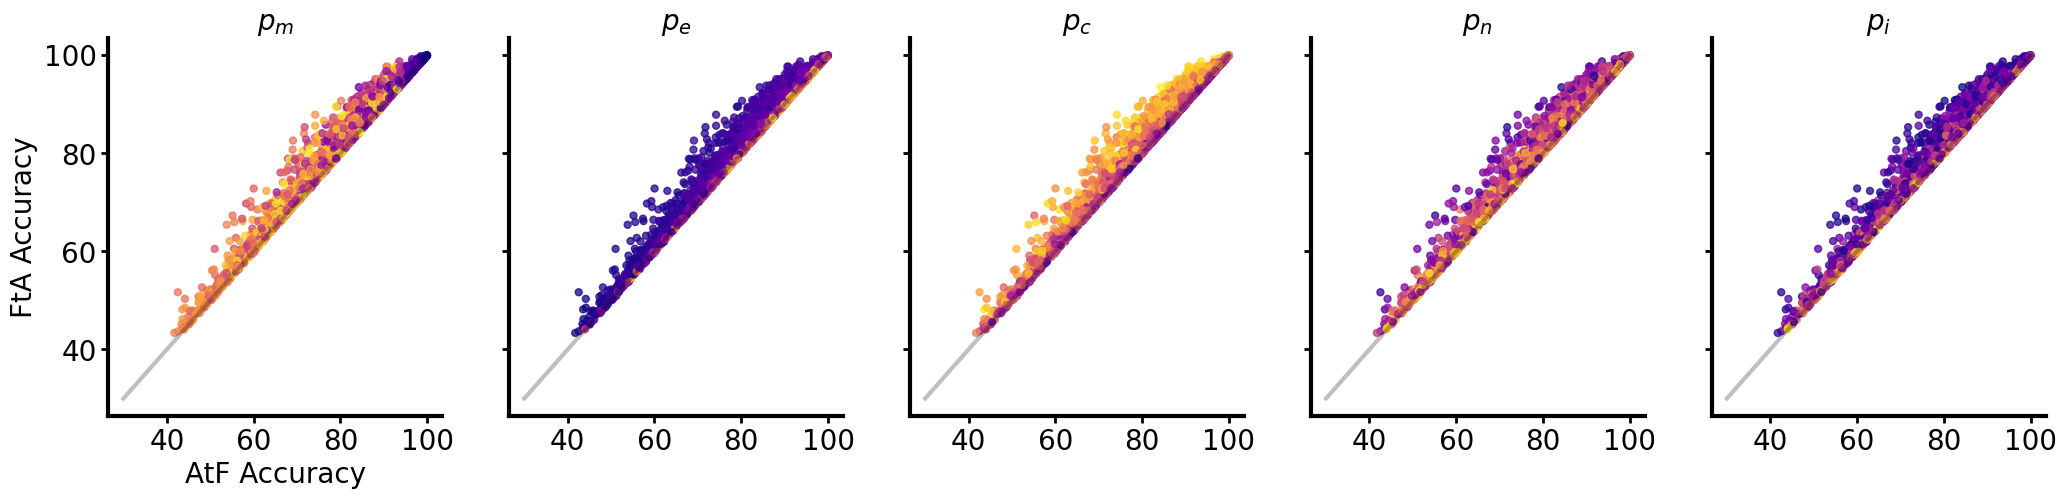

In [4]:
fig, ax = plt.subplots(
    1, len(p_ranges.keys()), figsize=(25, 5), sharex=True, sharey=True
)

for a, param in enumerate(p_ranges.keys()):
    plt.sca(ax[a])
    plt.scatter(
        accs[:, 0], accs[:, 1], c=params[:, a], cmap="plasma", marker=".", alpha=0.75
    )
    plt.plot([30, 100], [30, 100], "k", alpha=0.25)
    plt.title(p_labels[a])

    if a == 0:
        plt.xlabel("AtF Accuracy")
        plt.ylabel("FtA Accuracy")

Min diff: -0.34
Max diff: 13.67
Median diff: 0.73
Number of samples: 2836


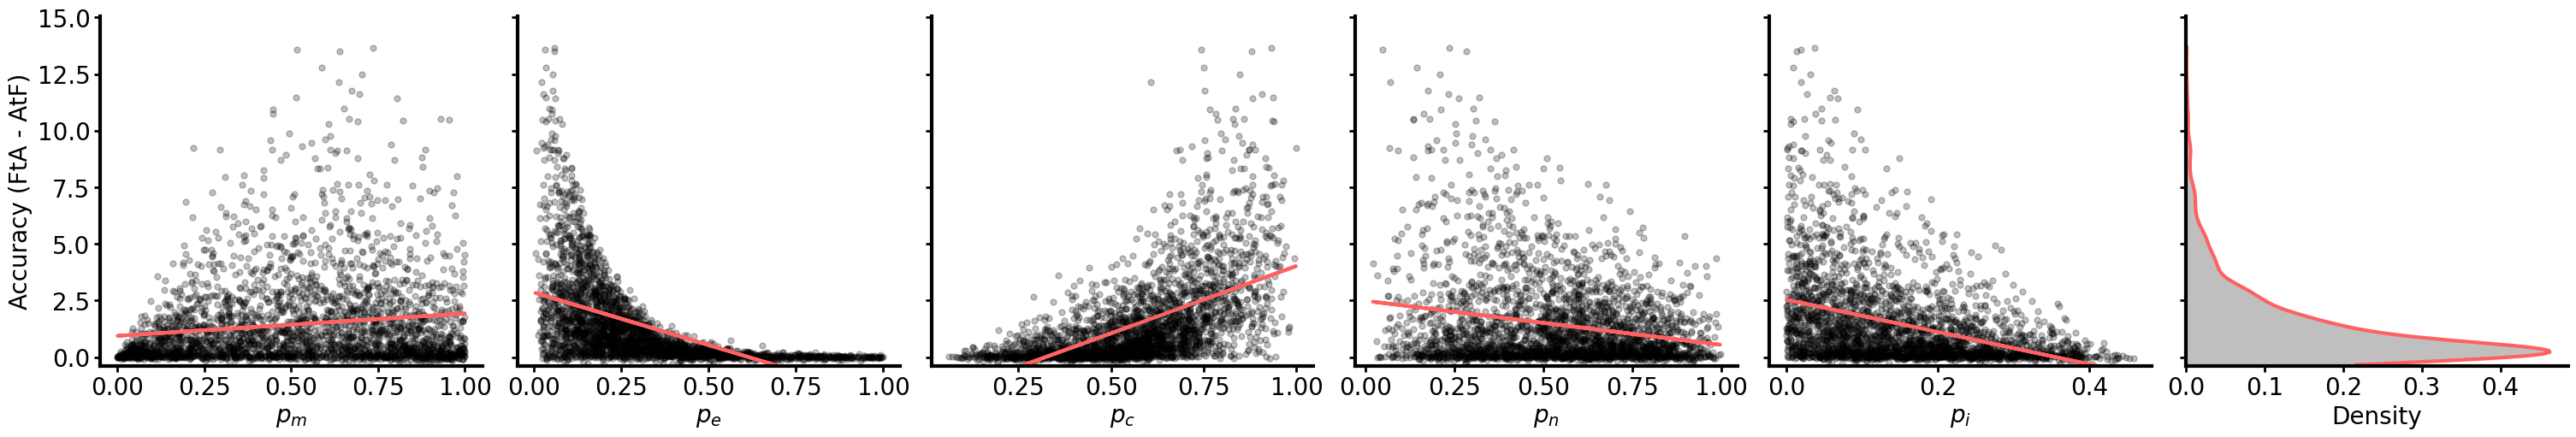

In [5]:
fig, ax = plt.subplots(
    1,
    len(p_ranges.keys()) + 1,
    figsize=(30, 5),
    sharex=False,
    sharey=True,
    constrained_layout=True,
)

for a, param in enumerate(p_ranges.keys()):
    plt.sca(ax[a])
    plt.scatter(params[:, a], accs_diff, color="k", marker=".", alpha=0.25)
    model = LinearRegression().fit(params[:, a][:, None], accs_diff)
    plt.plot(
        params[:, a],
        model.predict(params[:, a][:, None]),
        color="xkcd:coral pink",
        alpha=1.0,
    )
    plt.xlabel(p_labels[a])

    if a == 0:
        plt.ylabel("Accuracy (FtA - AtF)")

    plt.ylim([accs_diff.min() * 1.1, accs_diff.max() * 1.1])

plt.sca(ax[-1])
sns.kdeplot(y=accs_diff, cut=0, color="k", fill=True, alpha=0.25, linewidth=0.0)
sns.kdeplot(y=accs_diff, cut=0, color="xkcd:coral pink", fill=False, linewidth=3.0)

print("Min diff: " + str(np.round(accs_diff.min(), 2)))
print("Max diff: " + str(np.round(accs_diff.max(), 2)))
print("Median diff: " + str(np.round(np.median(accs_diff), 2)))
print("Number of samples: " + str(len(accs_diff)))

plt.savefig("detection_params_0.svg")


## Polynomial features 


In [6]:
X = pd.DataFrame.from_dict({k: p for k, p in zip(p_ranges.keys(), params.T)})
y = accs_diff
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
X_poly = poly.fit_transform(X)
keys = list(poly.get_feature_names_out())

# Inverse features
# X_poly = np.concatenate([X_poly, 1 / X_poly], -1)
# keys += [k + "_inv" for k in keys]

X_poly = pd.DataFrame({k: X_poly[:, i] for i, k in enumerate(keys)})
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y, test_size=0.33
)

## Random Forest

In [7]:
# Feature imortances
feature_importances = lambda rf: {
    f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)
}


Normal score: 0.9
Model score: 0.91


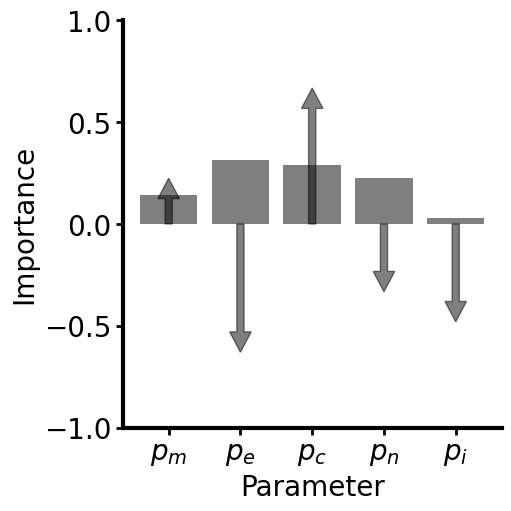

In [8]:
# Normal fit
rf = RF()
rf.fit(X_train, y_train)
print("Normal score: " + str(np.round(cross_val_score(rf, X, y, cv=10).mean(), 2)))
print("Model score: " + str(np.round(rf.score(X_test, y_test), 2)))

# Plotting
plot_data = {}
plot_data["feature"] = [k for k in feature_importances(rf).keys()]
plot_data["importance"] = list(feature_importances(rf).values())
plot_data["correlations"] = [
    np.corrcoef(X_train[k], y_train)[0, 1] for k in X_train.keys()
]
plot_data = pd.DataFrame.from_dict(plot_data)

# Bars
fig, ax = plt.subplots(constrained_layout=True)
sns.barplot(
    data=plot_data,
    x="feature",
    y="importance",
    ax=ax,
    color="k",
    alpha=0.5,
)
plt.xticks(range(len(p_labels)), p_labels)
ax.set_xlabel("Parameter")
ax.set_ylabel("Importance")
plt.ylim([-1.0, 1.0])

# Arrows
for i, corr in enumerate(plot_data["correlations"]):
    ax.arrow(
        i,  # x start point
        0,  # y start point
        0,  # change in x
        corr,  # change in y
        length_includes_head=False,
        head_width=0.3,  # arrow head width
        head_length=0.1,  # arrow head length
        width=0.1,  # arrow stem width
        fc="k",  # arrow fill color
        ec="k",  # arrow edge color
        alpha=0.5,
    )

plt.savefig("detection_params_1.svg")